<a href="https://colab.research.google.com/github/salwaa-hub/newtubes_machinelearning/blob/main/newtubes_machinelearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TUGAS BESAR MACHINE LEARNING SEMESTER 4 - SALWA SALSABILA DAFFA'ATULHAQ (4.33.23.2.25)**

***EDA***


=== STRUKTUR DATASET ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   Formatted Date            96453 non-null  datetime64[ns, UTC]
 1   Summary                   96453 non-null  object             
 2   Precip Type               95936 non-null  object             
 3   Temperature (C)           96453 non-null  float64            
 4   Apparent Temperature (C)  96453 non-null  float64            
 5   Humidity                  96453 non-null  float64            
 6   Wind Speed (km/h)         96453 non-null  float64            
 7   Wind Bearing (degrees)    96453 non-null  float64            
 8   Visibility (km)           96453 non-null  float64            
 9   Loud Cover                96453 non-null  float64            
 10  Pressure (millibars)      96453 non-null  float64       

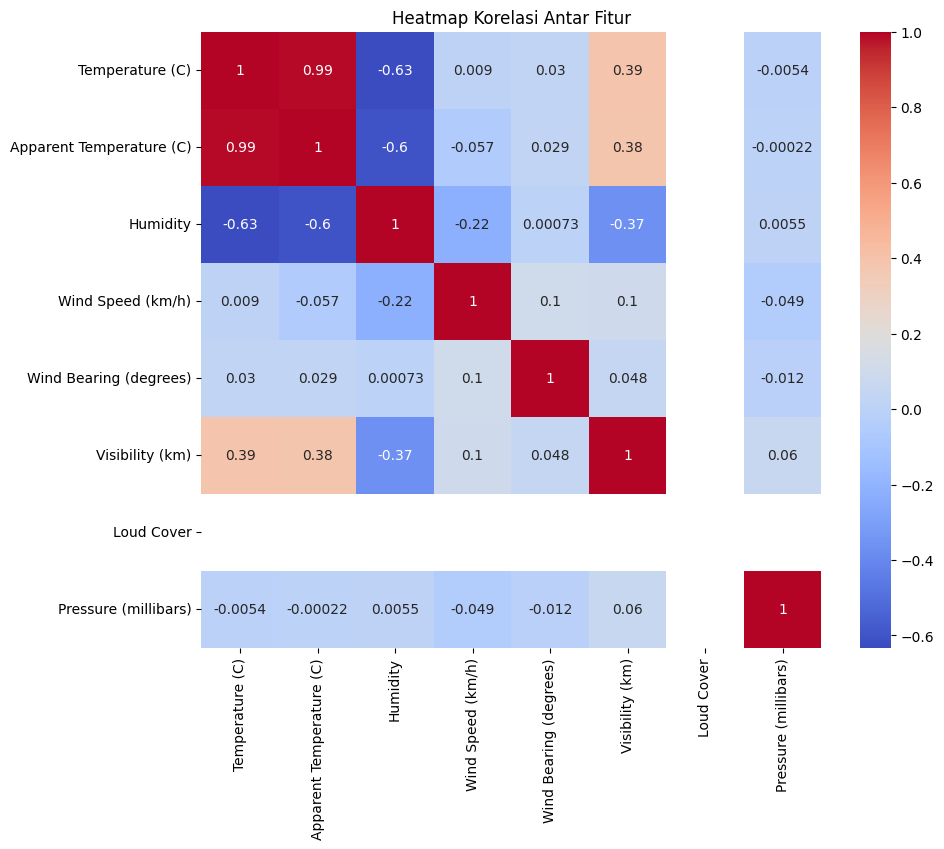


=== FITUR TERPILIH (Korelasi > 0.4 terhadap Temperature) ===
['Temperature (C)', 'Apparent Temperature (C)', 'Humidity']


In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load Dataset
file_path = "weatherHistory.csv"
df = pd.read_csv(file_path)

# Parsing Tanggal
df["Formatted Date"] = pd.to_datetime(df["Formatted Date"], utc=True)
df.sort_values("Formatted Date", inplace=True)
df.reset_index(drop=True, inplace=True)

# Info Struktur Data
print("\n=== STRUKTUR DATASET ===")
print(df.info())

# Statistik Deskriptif
print("\n=== STATISTIK DESKRIPTIF ===")
print(df.describe())

# Data Teratas
print("\n=== 5 BARIS PERTAMA ===")
print(df.head())

# Jumlah Kolom & Dimensi
print("\n=== DIMENSI DATASET ===")
print(f"Jumlah baris: {df.shape[0]}")
print(f"Jumlah kolom: {df.shape[1]}")

# Korelasi & Heatmap
numeric_df = df.select_dtypes(include=[np.number])
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm")
plt.title("Heatmap Korelasi Antar Fitur")
plt.show()

# Feature Selection Berdasarkan Korelasi dgn Target
correlation_matrix = numeric_df.corr()
target_corr = correlation_matrix["Temperature (C)"].abs().sort_values(ascending=False)
selected_features = target_corr[target_corr > 0.4].index.tolist()
print("\n=== FITUR TERPILIH (Korelasi > 0.4 terhadap Temperature) ===")
print(selected_features)

***Training Model LSTM dan RNN***

In [7]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, SimpleRNN, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping

# Praproses: Pilih dan Skala Fitur
df_model = df[selected_features].copy()
df_model.dropna(inplace=True)
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df_model)

# Sequence Creator
def create_sequences(data, seq_length=24):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, 1:])
        y.append(data[i+seq_length, 0])
    return np.array(X), np.array(y)

X, y = create_sequences(data_scaled)

# K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=False)

print("\n=== TRAINING LSTM & RNN (5-Fold, 100 Epoch + EarlyStopping) ===")
lstm_scores, rnn_scores = [], []

fold = 1
for train_idx, val_idx in kf.split(X):
    print(f"\n=== Fold {fold} ===")
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # ---- LSTM Model ----
    lstm = Sequential([
        Input(shape=X_train.shape[1:]),
        LSTM(64),
        Dropout(0.2),
        Dense(1)
    ])
    lstm.compile(optimizer='adam', loss='mse')
    lstm.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stop], verbose=1)
    y_pred_lstm = lstm.predict(X_val)
    lstm_scores.append((
        mean_squared_error(y_val, y_pred_lstm),
        mean_absolute_error(y_val, y_pred_lstm),
        r2_score(y_val, y_pred_lstm)
    ))

    # ---- RNN Model ----
    rnn = Sequential([
        Input(shape=X_train.shape[1:]),
        SimpleRNN(64),
        Dropout(0.2),
        Dense(1)
    ])
    rnn.compile(optimizer='adam', loss='mse')
    rnn.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stop], verbose=0)
    y_pred_rnn = rnn.predict(X_val)
    rnn_scores.append((
        mean_squared_error(y_val, y_pred_rnn),
        mean_absolute_error(y_val, y_pred_rnn),
        r2_score(y_val, y_pred_rnn)
    ))

    fold += 1

# Rata-rata Skor
def print_scores(scores, model_name):
    mse_avg = np.mean([s[0] for s in scores])
    mae_avg = np.mean([s[1] for s in scores])
    r2_avg = np.mean([s[2] for s in scores])
    print(f"\n== {model_name} AVG Scores ==")
    print(f"MSE: {mse_avg:.4f}, MAE: {mae_avg:.4f}, R²: {r2_avg:.4f}")

print_scores(lstm_scores, "LSTM")
print_scores(rnn_scores, "RNN")


=== TRAINING LSTM & RNN (5-Fold, 100 Epoch + EarlyStopping) ===

=== Fold 1 ===
Epoch 1/100
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 0.0083 - val_loss: 9.8047e-04
Epoch 2/100
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 0.0014 - val_loss: 6.9344e-04
Epoch 3/100
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 9.0220e-04 - val_loss: 6.8601e-04
Epoch 4/100
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 7.4651e-04 - val_loss: 6.3258e-04
Epoch 5/100
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 7.1104e-04 - val_loss: 6.2342e-04
Epoch 6/100
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - loss: 6.8527e-04 - val_loss: 6.6411e-04
Epoch 7/100
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - loss: 6.7023e-04 - val_loss: 6.1700e-04
Epoch 8/100
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 6.5654e-04 - val_loss: 6.1294e-04
Epoch 9/100
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - loss: 6.4293e-04 - val_loss: 6.0482e-04
Epoch 10/100
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 2

***Prediksi***

603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


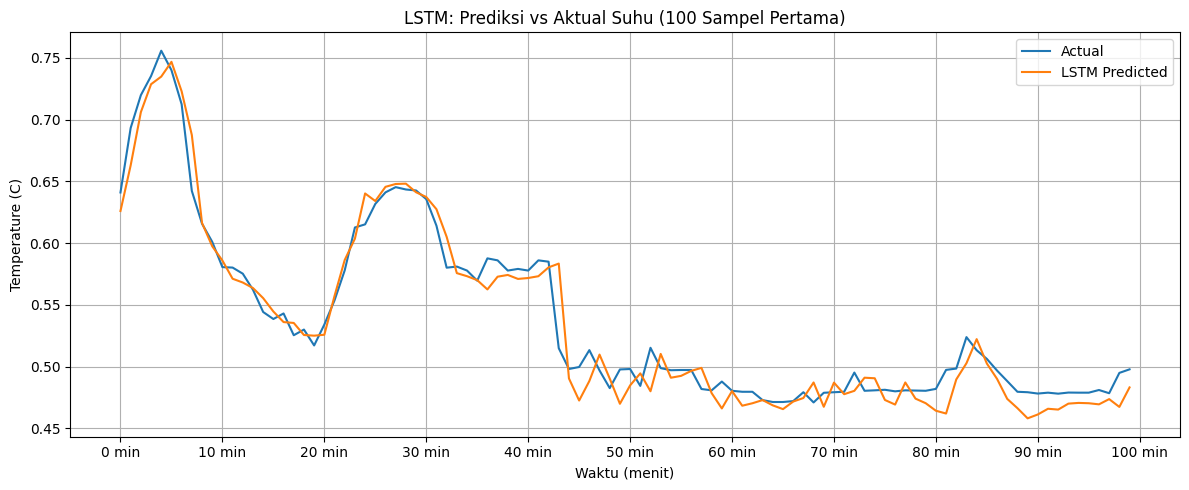


📋 [LSTM] Hasil Prediksi vs Aktual (10 Data Pertama):

Menit ke-01: Aktual = 0.64 °C | LSTM = 0.63 °C
Menit ke-02: Aktual = 0.69 °C | LSTM = 0.66 °C
Menit ke-03: Aktual = 0.72 °C | LSTM = 0.71 °C
Menit ke-04: Aktual = 0.74 °C | LSTM = 0.73 °C
Menit ke-05: Aktual = 0.76 °C | LSTM = 0.73 °C
Menit ke-06: Aktual = 0.74 °C | LSTM = 0.75 °C
Menit ke-07: Aktual = 0.71 °C | LSTM = 0.72 °C
Menit ke-08: Aktual = 0.64 °C | LSTM = 0.69 °C
Menit ke-09: Aktual = 0.62 °C | LSTM = 0.62 °C
Menit ke-10: Aktual = 0.60 °C | LSTM = 0.60 °C
603/603 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


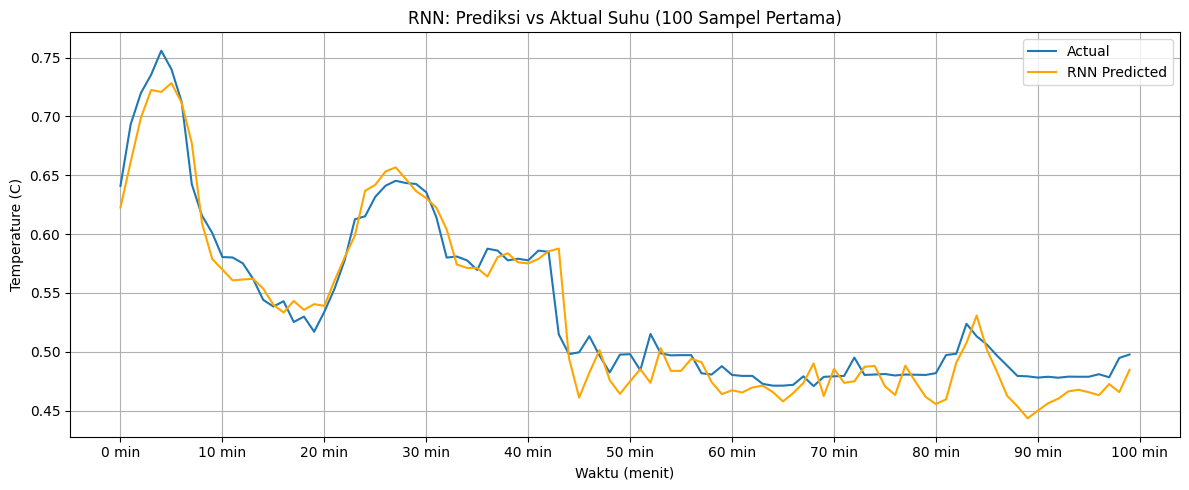


📋 [RNN] Hasil Prediksi vs Aktual (10 Data Pertama):

Menit ke-01: Aktual = 0.64 °C | RNN  = 0.62 °C
Menit ke-02: Aktual = 0.69 °C | RNN  = 0.66 °C
Menit ke-03: Aktual = 0.72 °C | RNN  = 0.70 °C
Menit ke-04: Aktual = 0.74 °C | RNN  = 0.72 °C
Menit ke-05: Aktual = 0.76 °C | RNN  = 0.72 °C
Menit ke-06: Aktual = 0.74 °C | RNN  = 0.73 °C
Menit ke-07: Aktual = 0.71 °C | RNN  = 0.71 °C
Menit ke-08: Aktual = 0.64 °C | RNN  = 0.68 °C
Menit ke-09: Aktual = 0.62 °C | RNN  = 0.61 °C
Menit ke-10: Aktual = 0.60 °C | RNN  = 0.58 °C
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step

🌡️ Prediksi suhu 1 jam ke depan:
  ▪️ LSTM: -1.19 °C
  ▪️ RNN : -1.17 °C

📊 Algoritma yang Paling Cocok:

🔹 LSTM (Long Short-Term Memory)
- Mampu menangkap pola musiman dan jangka panjang dari data suhu.
- Stabil dan akurat dalam prediksi time-series seperti cuaca harian.
- Hasil evaluasi 5-Fold menunjukkan performa lebih tinggi dari RNN.

🔸 RNN (Recurrent Neural Network) Sederhana
- Lebih ringa

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# 1. Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# 2. Gunakan model hasil 5-Fold terakhir
final_lstm = lstm  # model LSTM dari fold terakhir
final_rnn = rnn    # model RNN dari fold terakhir

# =======================
# 🔹 PREDIKSI DENGAN LSTM
# =======================
pred_lstm = final_lstm.predict(X_test)

plt.figure(figsize=(12, 5))
plt.plot(range(100), y_test[:100], label="Actual")
plt.plot(range(100), pred_lstm[:100], label="LSTM Predicted")
plt.xticks(ticks=range(0, 101, 10), labels=[f"{i} min" for i in range(0, 101, 10)])
plt.legend()
plt.title("LSTM: Prediksi vs Aktual Suhu (100 Sampel Pertama)")
plt.xlabel("Waktu (menit)")
plt.ylabel("Temperature (C)")
plt.grid(True)
plt.tight_layout()
plt.show()

print("\n📋 [LSTM] Hasil Prediksi vs Aktual (10 Data Pertama):\n")
for i in range(10):
    print(f"Menit ke-{i+1:02}: Aktual = {y_test[i]:.2f} °C | LSTM = {pred_lstm[i][0]:.2f} °C")

# =======================
# 🔸 PREDIKSI DENGAN RNN
# =======================
pred_rnn = final_rnn.predict(X_test)

plt.figure(figsize=(12, 5))
plt.plot(range(100), y_test[:100], label="Actual")
plt.plot(range(100), pred_rnn[:100], label="RNN Predicted", color='orange')
plt.xticks(ticks=range(0, 101, 10), labels=[f"{i} min" for i in range(0, 101, 10)])
plt.legend()
plt.title("RNN: Prediksi vs Aktual Suhu (100 Sampel Pertama)")
plt.xlabel("Waktu (menit)")
plt.ylabel("Temperature (C)")
plt.grid(True)
plt.tight_layout()
plt.show()

print("\n📋 [RNN] Hasil Prediksi vs Aktual (10 Data Pertama):\n")
for i in range(10):
    print(f"Menit ke-{i+1:02}: Aktual = {y_test[i]:.2f} °C | RNN  = {pred_rnn[i][0]:.2f} °C")

# =======================
# 🔮 Prediksi 1 jam ke depan (LSTM)
# =======================
last_sequence = data_scaled[-24:, 1:]
last_sequence = last_sequence.reshape((1, 24, last_sequence.shape[1]))

next_temp_lstm = final_lstm.predict(last_sequence)
temp_lstm = scaler.inverse_transform(
    np.hstack([next_temp_lstm, np.zeros((1, data_scaled.shape[1] - 1))])
)[0, 0]

next_temp_rnn = final_rnn.predict(last_sequence)
temp_rnn = scaler.inverse_transform(
    np.hstack([next_temp_rnn, np.zeros((1, data_scaled.shape[1] - 1))])
)[0, 0]

print(f"\n🌡️ Prediksi suhu 1 jam ke depan:")
print(f"  ▪️ LSTM: {temp_lstm:.2f} °C")
print(f"  ▪️ RNN : {temp_rnn:.2f} °C")

# =======================
# 📊 Penjelasan Algoritma
# =======================
print("""
📊 Algoritma yang Paling Cocok:

🔹 LSTM (Long Short-Term Memory)
- Mampu menangkap pola musiman dan jangka panjang dari data suhu.
- Stabil dan akurat dalam prediksi time-series seperti cuaca harian.
- Hasil evaluasi 5-Fold menunjukkan performa lebih tinggi dari RNN.

🔸 RNN (Recurrent Neural Network) Sederhana
- Lebih ringan dan cepat, namun sulit mengingat pola jangka panjang.
- Rentan terhadap vanishing gradient, sehingga prediksi bisa lebih meleset.

✅ Kesimpulan:
Untuk kasus prediksi suhu berdasarkan data historis,
LSTM adalah algoritma yang paling sesuai.
""")